In [7]:
import pandas as pd
import numpy as np

# Charger le fichier nettoyé d'origine
df = pd.read_csv("merged_data.csv", delimiter=",")

# Nettoyage de base : Supprimer les espaces superflus dans toutes les colonnes de type chaîne
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].str.strip()

# Conversion de TIME_PERIOD en numérique
df["TIME_PERIOD"] = pd.to_numeric(df["TIME_PERIOD"], errors="coerce")
df["TIME_PERIOD"] = df["TIME_PERIOD"].fillna(0).astype(int)

# Fonction pour calculer le point médian d'une tranche d'âge (ex: "15-24")
def calculer_milieu(age_range):
    try:
        parts = age_range.split("-")
        if len(parts) == 2:
            return (float(parts[0]) + float(parts[1])) / 2
        else:
            return np.nan
    except Exception as e:
        print(f"Erreur lors de la conversion de {age_range}: {e}")
        return np.nan

# Créer une nouvelle colonne 'age_numeric' à partir de la colonne 'age'
df["age_numeric"] = df["age"].apply(calculer_milieu)

# Supprimer la colonne 'age' d'origine pour éviter les conflits 
df = df.drop(columns=["age"])

# Imputer les valeurs manquantes pour les colonnes numériques avec la médiane
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Supprimer les doublons éventuels
df = df.drop_duplicates()

print(df.head())
print("\nNombre de lignes finales :", len(df))
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# Enregistrement du DataFrame final nettoyé dans un seul fichier CSV
df.to_csv("merged_data_clean.csv", index=False)

   TIME_PERIOD Sexe  Employed_Total  Unemployed_Total  Population_Active  \
0         2017    F        41769.91           2176.48           43946.39   
1         2017    F        48206.16           2894.20           51100.36   
2         2017    F        67030.20           1973.97           69004.16   
3         2017    F        58896.34           2673.11           61569.45   
4         2017    F        55307.87           5154.70           60462.57   

   Taux_Chomage (%)  company_count  avg_CRE_Measure  age_numeric  
0              4.95           1248            46.34         19.5  
1              5.66           1200            50.43         19.5  
2              2.86           1204            46.43         19.5  
3              4.34           1211            50.19         19.5  
4              8.53           1220            51.26         19.5  

Nombre de lignes finales : 1000

Valeurs manquantes par colonne :
TIME_PERIOD          0
Sexe                 0
Employed_Total       0
Unemp


Statistiques descriptives :
       TIME_PERIOD  Employed_Total  Unemployed_Total  Population_Active  \
count  1000.000000     1000.000000       1000.000000        1000.000000   
mean   2019.503000   123611.487220       7093.276290      130704.763760   
std       1.689036    58035.730519       5391.494402       61672.638476   
min    2017.000000    27442.760000        256.180000       28334.620000   
25%    2018.000000    66660.602500       2925.237500       71141.835000   
50%    2019.000000   118390.115000       5459.850000      125966.715000   
75%    2021.000000   166883.102500      10012.947500      176952.447500   
max    2022.000000   295611.000000      26899.780000      317853.280000   

       Taux_Chomage (%)  company_count  avg_CRE_Measure  age_numeric  
count        1000.00000    1000.000000      1000.000000  1000.000000  
mean            5.28691    1220.451000        50.626180    39.340000  
std             2.69011      76.775961         3.697483    15.201332  
min        

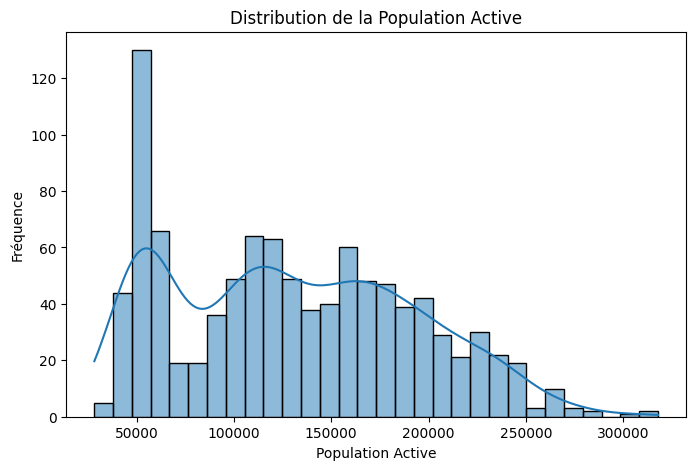

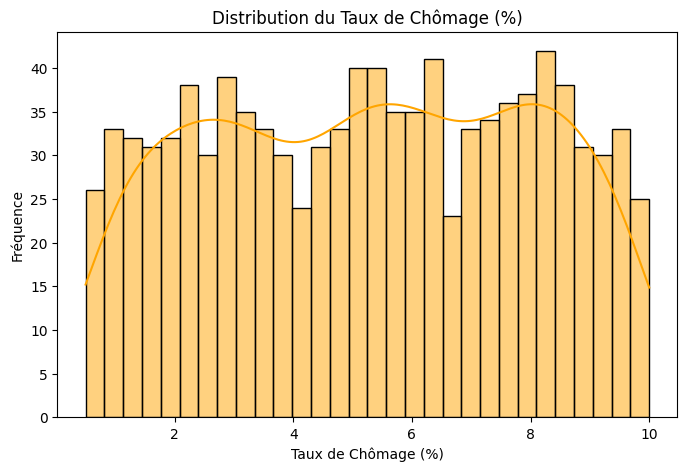

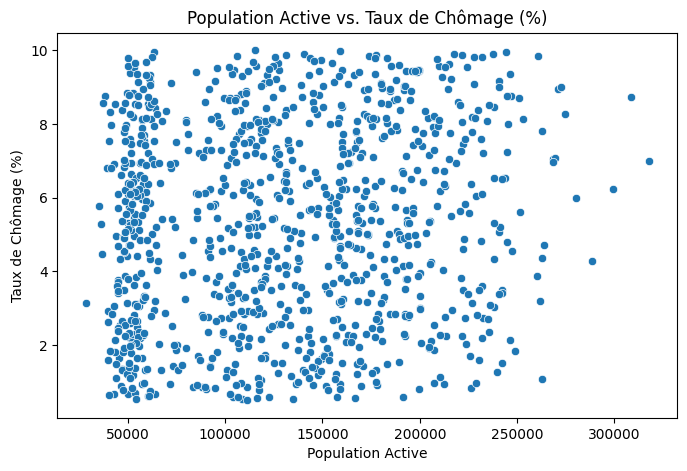

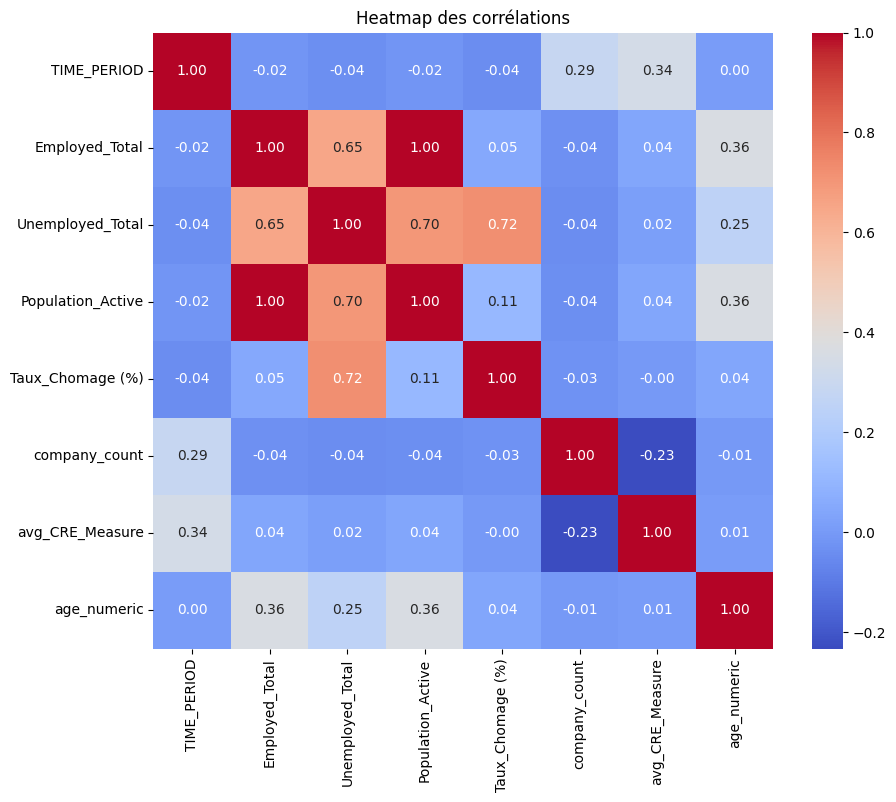

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Charger le fichier nettoyé
df = pd.read_csv("merged_data_clean.csv", delimiter=",")

# Affichage des statistiques descriptives globales (sur les colonnes numériques)
print("\nStatistiques descriptives :")
print(df.describe())

# Visualiser la distribution de la Population Active
plt.figure(figsize=(8, 5))
sns.histplot(df['Population_Active'], bins=30, kde=True)
plt.title("Distribution de la Population Active")
plt.xlabel("Population Active")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la distribution du Taux de Chômage (%)
plt.figure(figsize=(8, 5))
sns.histplot(df['Taux_Chomage (%)'], bins=30, kde=True, color="orange")
plt.title("Distribution du Taux de Chômage (%)")
plt.xlabel("Taux de Chômage (%)")
plt.ylabel("Fréquence")
plt.show()

# Visualiser la relation entre Population Active et Taux de Chômage
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Population_Active', y='Taux_Chomage (%)', data=df)
plt.title("Population Active vs. Taux de Chômage (%)")
plt.xlabel("Population Active")
plt.ylabel("Taux de Chômage (%)")
plt.show()

# Pour la heatmap, on sélectionne uniquement les colonnes numériques
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap des corrélations")
plt.show()


In [17]:
# La population active correspond aux personnes avec Status_EMP "1" (Actif occupé) et "2" (Chômeur)
df_active = df[df["Status_EMP"].isin([1, 2])].copy()

print("\nPopulation active (Status_EMP == 1 ou 2) :", df_active.shape[0])

# -------------------------------
# 4. Agrégation par groupe (Time_Period, age, Sexe)
# -------------------------------
# Pour les employés (Status_EMP == 1), on agrège la colonne "Measure"
df_emp = df_active[df_active["Status_EMP"] == 1].copy()
emp_agg = df_emp.groupby(["Time_Period", "age", "Sexe"])["Measure"].sum().reset_index()
emp_agg.rename(columns={"Measure": "Employed_Total"}, inplace=True)

# Pour les chômeurs (Status_EMP == 2), on agrège la colonne "CHOM_Value"
df_chom = df_active[df_active["Status_EMP"] == 2].copy()
chom_agg = df_chom.groupby(["Time_Period", "age", "Sexe"])["CHOM_Value"].sum().reset_index()
chom_agg.rename(columns={"CHOM_Value": "Unemployed_Total"}, inplace=True)

# -------------------------------
# 5. Fusion des agrégations
# -------------------------------
# Fusion externe pour conserver tous les groupes
indicators_df = pd.merge(emp_agg, chom_agg, on=["Time_Period", "age", "Sexe"], how="outer")

# Remplacer les valeurs manquantes par 0
indicators_df["Employed_Total"] = indicators_df["Employed_Total"].fillna(0)
indicators_df["Unemployed_Total"] = indicators_df["Unemployed_Total"].fillna(0)

# Calcul de la population active
indicators_df["Population_Active"] = indicators_df["Employed_Total"] + indicators_df["Unemployed_Total"]

# Calcul du taux de chômage (%) = (Chômeurs / Population active) * 100
# (Si Population_Active est 0, le résultat sera NaN)
indicators_df["Taux_Chomage (%)"] = (indicators_df["Unemployed_Total"] / indicators_df["Population_Active"]) * 100

print("\nIndicateurs de la population active et du chômage pour Perpignan :")
print(indicators_df.sort_values(["Time_Period", "age", "Sexe"]))

#save into csv file
output_filename = "indicateurs_POP_CHOM.csv"
indicators_df.to_csv(output_filename, index=False)
print(f"\nLes indicateurs ont été enregistrés dans le fichier '{output_filename}'.")


Population active (Status_EMP == 1 ou 2) : 328

Indicateurs de la population active et du chômage pour Perpignan :
    Time_Period    age Sexe  Employed_Total  Unemployed_Total  \
0          2017   0-10    F   144447.708607          732.3350   
1          2017   0-10    M    51744.097719         1935.3102   
2          2017  11-20    F    76273.733038          959.6228   
3          2017  11-20    M    39014.684864         1116.5800   
4          2017  21-30    F   152780.559404            0.0000   
5          2017  21-30    M    15675.800718         1507.5678   
6          2017  31-40    F   217365.011886         1740.2463   
7          2017  31-40    M   144374.906755          872.1684   
8          2017  41-50    F   226831.019570         1138.9080   
9          2017  41-50    M    26395.843613          880.6904   
10         2018   0-10    F   214947.540290         2906.7647   
11         2018   0-10    M   285816.492956         1288.5651   
12         2018  11-20    F    16603.75

In [4]:
import pandas as pd
import numpy as np

# 1. Charger le fichier initial
df = pd.read_csv("indicateurs_POP_CHOM.csv", delimiter=",")
print("Nombre total de lignes avant correction :", len(df))

# 2. Exclure les lignes avec un taux de chômage >= 100%
mask_100 = df["Taux_Chomage (%)"] >= 100
print("Nombre de lignes avec 100% (ou plus) de chômage :", mask_100.sum())
df = df[~mask_100].copy()
print("Nombre total de lignes après exclusion des taux aberrants :", len(df))

# 3. Exclure la tranche d'âge "0-10" (non considérée comme population active)
df = df[df["age"] != "0-10"]

# 4. Correction des cas où le taux de chômage est 0 et le nombre de chômeurs est également 0
mask_zero = (df["Taux_Chomage (%)"] == 0) & (df["Unemployed_Total"] == 0)
df.loc[mask_zero, "Taux_Chomage (%)"] = pd.NA

# 5. Imputation des valeurs manquantes dans "Taux_Chomage (%)" avec la médiane par groupe (age & Sexe)
df["Taux_Chomage (%)"] = df.groupby(["age", "Sexe"])["Taux_Chomage (%)"].transform(lambda x: x.fillna(x.median()))

# Vérification finale
print("\nAperçu final après corrections :")
print(df.head())

# 6. Enregistrer le résultat final dans un seul fichier CSV nommé 'indicateur.csv'
df.to_csv("indicateur_POP_clean.csv", index=False)
print("\nLes données corrigées ont été enregistrées dans 'indicateur.csv'")


Nombre total de lignes avant correction : 60
Nombre de lignes avec 100% (ou plus) de chômage : 4
Nombre total de lignes après exclusion des taux aberrants : 56

Aperçu final après corrections :
   Time_Period    age Sexe  Employed_Total  Unemployed_Total  \
2         2017  11-20    F    76273.733038          959.6228   
3         2017  11-20    M    39014.684864         1116.5800   
4         2017  21-30    F   152780.559404            0.0000   
5         2017  21-30    M    15675.800718         1507.5678   
6         2017  31-40    F   217365.011886         1740.2463   

   Population_Active  Taux_Chomage (%)  
2       77233.355838          1.242498  
3       40131.264864          2.782319  
4      152780.559404          0.980076  
5       17183.368518          8.773412  
6      219105.258186          0.794251  

Les données corrigées ont été enregistrées dans 'indicateur.csv'


In [5]:
import pandas as pd
import random

# Nombre de lignes souhaitées
n = 1000

# Définition des tranches d'âge et des sexes
age_groups = ["15-24", "25-39", "40-54"]
sexes = ["F", "M"]

data = []

for _ in range(n):
    # Année aléatoire entre 2017 et 2022
    year = random.randint(2017, 2022)
    # Choix aléatoire d'une tranche d'âge et d'un sexe
    age = random.choice(age_groups)
    sexe = random.choice(sexes)
    
    # Génération de valeurs selon la tranche d'âge
    if age == "15-24":
        employed = random.uniform(10000, 40000)
        # On suppose un taux de chômage entre environ 1% et 15%
        unemployed = random.uniform(500, employed * 0.15)
    elif age == "25-39":
        employed = random.uniform(30000, 100000)
        unemployed = random.uniform(1000, employed * 0.1)
    elif age == "40-54":
        employed = random.uniform(20000, 80000)
        unemployed = random.uniform(1000, employed * 0.1)
    
    # Calcul de la population active et du taux de chômage
    population = employed + unemployed
    taux = (unemployed / population) * 100
    
    data.append({
        "Time_Period": year,
        "age": age,
        "Sexe": sexe,
        "Employed_Total": round(employed, 2),
        "Unemployed_Total": round(unemployed, 2),
        "Population_Active": round(population, 2),
        "Taux_Chomage (%)": round(taux, 2)
    })

# Création du DataFrame
df = pd.DataFrame(data)

# Enregistrement dans un seul fichier CSV
df.to_csv("indicateurs_POP_CHOM_synthetique.csv", index=False)
print("Fichier CSV généré avec", len(df), "lignes.")


Fichier CSV généré avec 1000 lignes.


In [9]:
#**************************ENTREPRISE*****************************

import pandas as pd
import numpy as np

df_company = pd.read_csv("COMPANY.csv", delimiter=",", quotechar='"')

print("Aperçu initial :")
print(df_company.head())
print("\nInformations :")
print(df_company.info())

df_company = df_company.applymap(lambda x: x.strip() if isinstance(x, str) else x)

#  Vérifications post-nettoyage

print("\nAperçu après nettoyage :")
print(df_company.head(10))

# Enregistrement des données nettoyées
df_company.to_csv("COMPANY_cleaned.csv", index=False)
print("\nLes données nettoyées ont été enregistrées dans 'COMPANY_cleaned.csv'.")


Aperçu initial :
   Geo_code  TIME_PERIOD company_activity Legal_Form   company_base  \
0     66136         2019     Construction   OTH_SIDE       National   
1     66136         2022          Finance         54  International   
2     66136         2018        Education         10          Local   
3     66136         2020            Santé         10       National   
4     66136         2018        Education   OTH_SIDE          Local   

   CRE_Measure  
0           43  
1           55  
2           30  
3           10  
4           88  

Informations :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Geo_code          1000 non-null   int64 
 1   TIME_PERIOD       1000 non-null   int64 
 2   company_activity  1000 non-null   object
 3   Legal_Form        1000 non-null   object
 4   company_base      1000 non-null   object
 5   CRE_Me

C:\Users\DELL\AppData\Local\Temp\ipykernel_956\2868258750.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_company = df_company.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [10]:
#**************************Pauvreté**********************************

import pandas as pd
import numpy as np

df = pd.read_csv("Poverty.csv", delimiter=",")

for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].str.strip()

df["poverty_population"] = pd.to_numeric(df["poverty_population"], errors="coerce")
df["poverty_rate"] = pd.to_numeric(df["poverty_rate"], errors="coerce")

# Vérifier et gérer les valeurs manquantes
print("\nNombre de valeurs manquantes par colonne avant imputation :")
print(df.isna().sum())

# Ici, nous pouvons imputer la médiane pour 'poverty_rate' s'il y a des valeurs manquantes
df["poverty_rate"].fillna(df["poverty_rate"].median(), inplace=True)

print("\nNombre de valeurs manquantes par colonne après traitement :")
print(df.isna().sum())

output_filename = "Poverty_cleaned.csv"
df.to_csv(output_filename, index=False)
print(f"\nLe fichier nettoyé a été enregistré sous '{output_filename}'")



Nombre de valeurs manquantes par colonne avant imputation :
GEO_Code                      0
poverty_affected_age_group    0
Sexe                          0
poverty_population            0
poverty_causes                0
poverty_rate                  0
dtype: int64

Nombre de valeurs manquantes par colonne après traitement :
GEO_Code                      0
poverty_affected_age_group    0
Sexe                          0
poverty_population            0
poverty_causes                0
poverty_rate                  0
dtype: int64

Le fichier nettoyé a été enregistré sous 'Poverty_cleaned.csv'


C:\Users\DELL\AppData\Local\Temp\ipykernel_956\1474721907.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["poverty_rate"].fillna(df["poverty_rate"].median(), inplace=True)


In [ ]:
#*********************fusion**************************

import pandas as pd

# Read the datasets
df_popchom = pd.read_csv("indicateur_POP_clean.csv", delimiter=",")
df_company  = pd.read_csv("COMPANY_cleaned.csv", delimiter=",")

if 'time_Period' in df_popchom.columns:
    df_popchom.rename(columns={'time_Period': 'TIME_PERIOD'}, inplace=True)
elif 'Time_Period' in df_popchom.columns:
    df_popchom.rename(columns={'Time_Period': 'TIME_PERIOD'}, inplace=True)
    
if 'time_Period' in df_company.columns:
    df_company.rename(columns={'time_Period': 'TIME_PERIOD'}, inplace=True)
elif 'Time_Period' in df_company.columns:
    df_company.rename(columns={'Time_Period': 'TIME_PERIOD'}, inplace=True)


company_agg = df_company.groupby("TIME_PERIOD").agg(
    company_count = ("company_activity", "count"),
    avg_CRE_Measure = ("CRE_Measure", "mean")
).reset_index()

print("Aggregated company data:")
print(company_agg.head())

# Merge the pop/chom data with the aggregated company data on TIME_PERIOD.
merged_df = pd.merge(df_popchom, company_agg, on="TIME_PERIOD", how="left")

# sort by TIME_PERIOD
merged_df.sort_values("TIME_PERIOD", inplace=True)

# Save the merged data to a CSV file
merged_df.to_csv("merged_popchom_company.csv", index=False)
print("Merged file saved as 'merged_popchom_company_simple.csv'")


Aggregated company data:
   TIME_PERIOD  company_count  avg_CRE_Measure
0         2017            153        51.679739
1         2018            175        47.342857
2         2019            159        50.490566
3         2020            170        52.870588
4         2021            168        49.648810
Merged file saved as 'merged_popchom_company_simple.csv'
